# High-Performance Dyslexia Text Simplification Model
## Complete Training & Deployment Pipeline
### Overview
This notebook creates a state-of-the-art text simplification model specifically designed for dyslexic learners, trained on WikiAuto and fine-tuned on educational content.

## Download Language Models

In [1]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

!python -m spacy download en_core_web_sm

print("✅ All dependencies installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.8 MB/s eta 0:00:003.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✅ All dependencies installed successfully!


### Import Libraries & Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm
import json
import pickle
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# NLP & ML
import nltk
import spacy
import textstat
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Transformers
from transformers import (
    T5ForConditionalGeneration, T5Tokenizer,
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Trainer, TrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from datasets import Dataset, load_dataset
import evaluate

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configure matplotlib
plt.style.use('default')
sns.set_palette("husl")

print("🚀 Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Device configuration (optimized for MacBook)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("🔥 Using NVIDIA GPU")
else:
    device = torch.device("cpu")
    print("💻 Using CPU")

🚀 Setup complete!
PyTorch version: 2.5.1
CUDA available: False
🍎 Using Apple Silicon GPU (MPS)


##  Data Loading & Exploration
### Load WikiAuto Dataset

In [3]:
# Load WikiAuto dataset from HuggingFace
print("📥 Loading WikiAuto dataset...")

try:
    # Load the full WikiAuto dataset
    dataset = load_dataset("wiki_auto", trust_remote_code=True)
    print("✅ WikiAuto dataset loaded successfully!")
except:
    try:
        # Alternative: Load from GEM
        dataset = load_dataset("GEM/wiki_auto_asset_turk")
        print("✅ WikiAuto (GEM version) loaded successfully!")
    except:
        # Fallback: Create sample dataset
        print("⚠️ Creating sample dataset...")
        sample_data = {
            'source': [
                "Photosynthesis is a complex biochemical process that occurs in plants, algae, and certain bacteria, converting light energy into chemical energy stored in glucose molecules.",
                "The mitochondrion is often referred to as the powerhouse of the cell because it generates most of the cell's supply of adenosine triphosphate, used as a source of chemical energy.",
                "Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the molecular, atomic, nuclear, and even smaller microscopic levels.",
                "The periodic table is a tabular arrangement of the chemical elements, ordered by their atomic number, electron configuration, and recurring chemical properties.",
                "DNA replication is a biological process occurring in all living organisms that copies their DNA; this process is the basis for biological inheritance.",
                "Photosynthesis converts carbon dioxide and water into glucose using sunlight energy, releasing oxygen as a byproduct in the process.",
                "Newton's laws of motion are three physical laws that form the foundation for classical mechanics, describing the relationship between forces and motion.",
                "The electromagnetic spectrum comprises all types of electromagnetic radiation, from radio waves with the lowest frequencies to gamma rays with the highest frequencies.",
                "Cellular respiration is a metabolic process that cells use to extract energy from nutrients, primarily glucose, converting it into adenosine triphosphate.",
                "Evolution is the change in heritable traits of biological populations over successive generations, driven by mechanisms such as natural selection."
            ],
            'target': [
                "Plants make food from sunlight. This process is called photosynthesis. Plants use light to make sugar.",
                "Mitochondria make energy for cells. They are like tiny power plants inside cells.",
                "Quantum mechanics explains how very small things work. It tells us about atoms and particles.",
                "The periodic table shows all chemical elements. Elements are arranged by their properties.",
                "DNA copying happens in all living things. This is how traits pass from parents to children.",
                "Plants use sunlight to make food. They take in carbon dioxide and water. They make sugar and oxygen.",
                "Newton made three laws about how things move. These laws explain forces and motion.",
                "Light comes in many types. Radio waves, visible light, and X-rays are all types of light.",
                "Cells break down food to get energy. They turn sugar into energy the cell can use.",
                "Evolution means living things change over time. Natural selection helps species survive better."
            ]
        }
        dataset = {'train': Dataset.from_dict(sample_data)}

# Display dataset information
print(f"\n📊 Dataset Information:")
for split in dataset.keys():
    print(f"   {split}: {len(dataset[split]):,} examples")

# Show sample
sample = dataset['train'][0]
print(f"\n📝 Sample Example:")
print(f"Source: {sample['source'][:100]}...")
print(f"Target: {sample['target'][:100]}...")

📥 Loading WikiAuto dataset...


Generating challenge_validation_sample split: 100%|██████████| 500/500 [00:00<00:00, 399990.84 examples/s]
Generating challenge_test_asset_backtranslation split: 100%|██████████| 359/359 [00:00<00:00, 306608.66 examples/s]
Generating challenge_test_asset_nopunc split: 100%|██████████| 359/359 [00:00<00:00, 339363.34 examples/s]
Generating challenge_test_turk_backtranslation split: 100%|██████████| 359/359 [00:00<00:00, 334315.08 examples/s]
Generating challenge_test_turk_nopunc split: 100%|██████████| 359/359 [00:00<00:00, 196061.87 examples/s]

✅ WikiAuto (GEM version) loaded successfully!

📊 Dataset Information:
   train: 483,801 examples
   validation: 20,000 examples
   test_asset: 359 examples
   test_turk: 359 examples
   test_contract: 659 examples
   test_wiki: 720 examples
   challenge_train_sample: 500 examples
   challenge_validation_sample: 500 examples
   challenge_test_asset_backtranslation: 359 examples
   challenge_test_asset_bfp02: 359 examples
   challenge_test_asset_bfp05: 359 examples
   challenge_test_asset_nopunc: 359 examples
   challenge_test_turk_backtranslation: 359 examples
   challenge_test_turk_bfp02: 359 examples
   challenge_test_turk_bfp05: 359 examples
   challenge_test_turk_nopunc: 359 examples

📝 Sample Example:
Source: Pterocarpus indicus ( commonly known as Amboyna wood , Malay padauk , Papua New Guinea rosewood , Ph...
Target: Pterocarpus indicus ( commonly known as Amboyna wood , Malay padauk , Papua New Guinea rosewood , Ph...


### Create Educational Fine-tuning Dataset

In [4]:
# Create comprehensive educational dataset for fine-tuning
educational_content = {
    'mathematics': [
        {
            'source': "The quadratic formula x = (-b ± √(b² - 4ac)) / 2a is used to solve quadratic equations of the form ax² + bx + c = 0, where a, b, and c are coefficients and a ≠ 0.",
            'target': "To solve x² + bx + c = 0, use this formula: x = (-b ± √(b² - 4ac)) / 2a. Here a, b, and c are numbers from your equation."
        },
        {
            'source': "Integration is the reverse mathematical operation of differentiation and represents the calculation of the area under a curve or the accumulation of quantities over an interval.",
            'target': "Integration is the opposite of finding slopes. It helps us find the area under curved lines on graphs."
        },
        {
            'source': "A polynomial is an expression consisting of variables and coefficients, involving only addition, subtraction, multiplication, and non-negative integer exponentiation of variables.",
            'target': "A polynomial is a math expression with variables and numbers. You can add, subtract, and multiply the parts."
        },
        {
            'source': "The Pythagorean theorem states that in a right triangle, the square of the length of the hypotenuse equals the sum of squares of the lengths of the other two sides.",
            'target': "In a right triangle, a² + b² = c². Here c is the longest side, and a and b are the other sides."
        }
    ],
    'physics': [
        {
            'source': "Newton's second law of motion states that the acceleration of an object is directly proportional to the net force acting on it and inversely proportional to its mass, expressed as F = ma.",
            'target': "Newton's second law says Force = mass × acceleration. More force makes things speed up faster. Heavier things are harder to speed up."
        },
        {
            'source': "Electromagnetic radiation consists of oscillating electric and magnetic fields that propagate through space at the speed of light, encompassing radio waves, visible light, and gamma rays.",
            'target': "Light is made of electric and magnetic waves. These waves move at light speed. Radio, visible light, and X-rays are all the same type of wave."
        },
        {
            'source': "The conservation of energy principle states that energy cannot be created or destroyed in an isolated system, only transformed from one form to another.",
            'target': "Energy cannot be made or destroyed. It can only change from one type to another type."
        },
        {
            'source': "Gravitational force is an attractive force between any two objects with mass, proportional to their masses and inversely proportional to the square of the distance between them.",
            'target': "Gravity pulls objects together. Bigger objects have stronger gravity. Objects farther apart have weaker gravity between them."
        }
    ],
    'chemistry': [
        {
            'source': "Covalent bonds form when atoms share electrons to achieve a stable electron configuration, typically following the octet rule where atoms seek eight electrons in their outermost shell.",
            'target': "Atoms share electrons to make covalent bonds. This sharing helps atoms become stable by filling their outer shell."
        },
        {
            'source': "The pH scale measures the acidity or alkalinity of a solution, ranging from 0 to 14, where 7 is neutral, values below 7 are acidic, and values above 7 are basic.",
            'target': "pH measures how acidic or basic something is. 7 is neutral. Numbers below 7 are acidic. Numbers above 7 are basic."
        },
        {
            'source': "Chemical equilibrium occurs when the rate of the forward reaction equals the rate of the reverse reaction, resulting in constant concentrations of reactants and products.",
            'target': "Chemical equilibrium happens when reactions balance out. The forward and backward reactions go at the same speed."
        },
        {
            'source': "Oxidation-reduction reactions involve the transfer of electrons between substances, where oxidation is the loss of electrons and reduction is the gain of electrons.",
            'target': "In redox reactions, electrons move between substances. Oxidation means losing electrons. Reduction means gaining electrons."
        }
    ],
    'biology': [
        {
            'source': "Mitosis is a type of cell division that results in two daughter cells each having the same number and kind of chromosomes as the parent nucleus, essential for growth and repair.",
            'target': "Mitosis is when one cell splits into two identical cells. Each new cell has the same genetic information as the parent."
        },
        {
            'source': "Photosynthesis is the complex process by which plants, algae, and some bacteria convert light energy into chemical energy stored in glucose, using carbon dioxide and water.",
            'target': "Plants use sunlight to make sugar for food. They take in carbon dioxide and water. This process is called photosynthesis."
        },
        {
            'source': "Natural selection is the differential survival and reproduction of individuals due to differences in phenotype, leading to evolutionary changes in populations over time.",
            'target': "Natural selection means the best-adapted organisms survive and reproduce. This causes species to change over time."
        },
        {
            'source': "The central dogma of molecular biology describes the flow of genetic information from DNA to RNA to protein through transcription and translation processes.",
            'target': "Genetic information flows from DNA to RNA to proteins. This happens through copying and translating genetic codes."
        }
    ],
    'computer_science': [
        {
            'source': "Object-oriented programming is a programming paradigm based on the concept of objects, which contain data in the form of fields and code in the form of procedures called methods.",
            'target': "Object-oriented programming groups related data and functions together in objects. This makes code easier to organize and understand."
        },
        {
            'source': "Machine learning algorithms enable computers to automatically learn and improve from experience without being explicitly programmed for every specific task.",
            'target': "Machine learning teaches computers to learn from examples. The computer finds patterns in data by itself without specific instructions."
        },
        {
            'source': "Data structures are specialized formats for organizing, processing, retrieving and storing data, such as arrays, linked lists, stacks, queues, trees, and graphs.",
            'target': "Data structures are ways to organize information in computers. Examples include lists, stacks, and trees."
        },
        {
            'source': "Algorithms are step-by-step procedures or formulas for solving problems, typically implemented in computer programs to perform calculations or data processing tasks.",
            'target': "Algorithms are step-by-step instructions for solving problems. They tell computers exactly what to do."
        }
    ]
}

# Convert to dataset format
educational_examples = []
for subject, examples in educational_content.items():
    for example in examples:
        educational_examples.append({
            'source': example['source'],
            'target': example['target'],
            'subject': subject,
            'domain': 'educational'
        })

educational_dataset = Dataset.from_list(educational_examples)
print(f"📚 Created educational dataset with {len(educational_examples)} examples")
print(f"📋 Subjects: {list(educational_content.keys())}")

📚 Created educational dataset with 20 examples
📋 Subjects: ['mathematics', 'physics', 'chemistry', 'biology', 'computer_science']


## Data Visualization & Analysis

### Comprehensive Data Analysis

🔍 Analyzing WikiAuto Dataset...


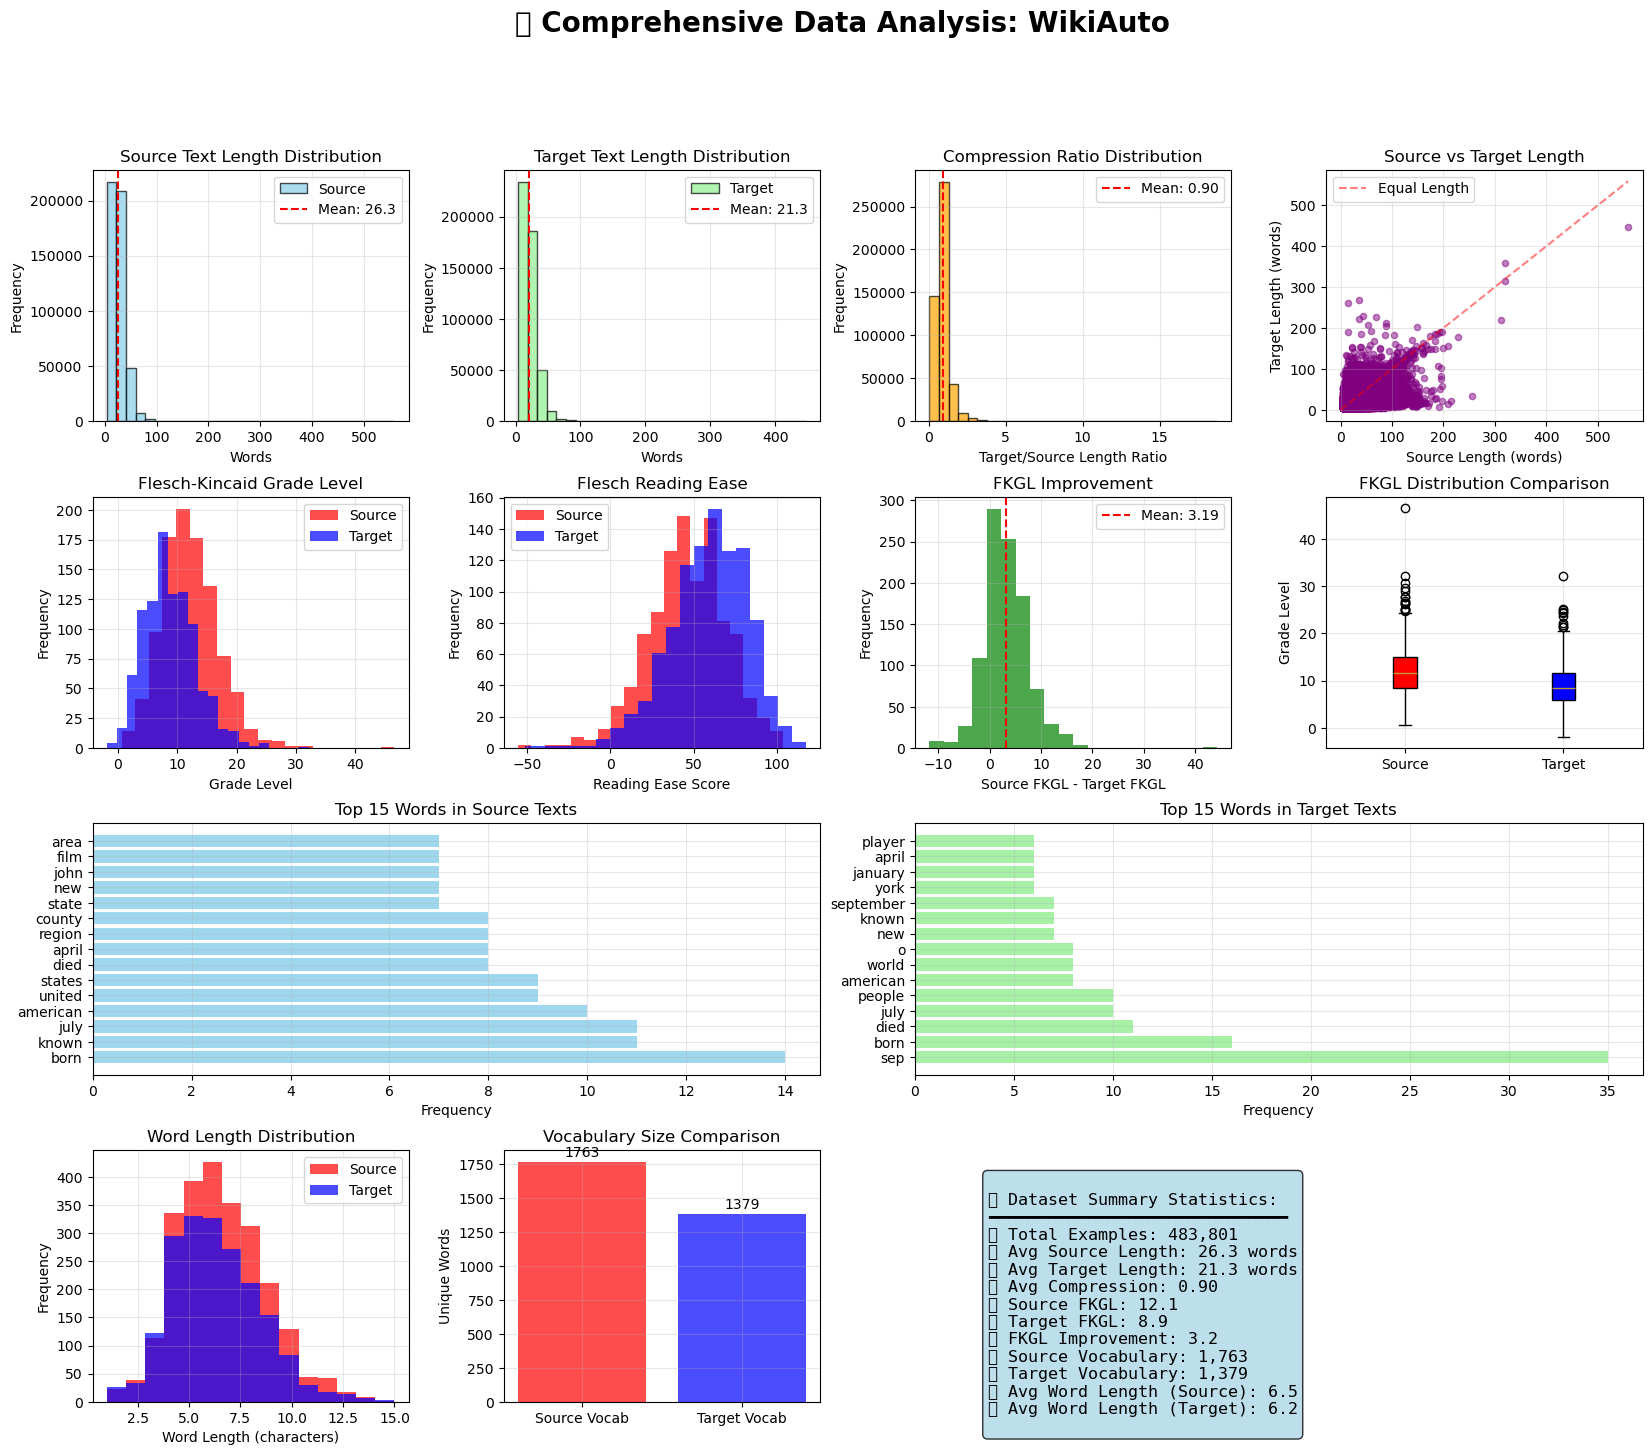

In [6]:
def analyze_dataset_comprehensively(dataset, name):
    """Comprehensive analysis of the dataset"""
    
    if 'train' in dataset:
        data = dataset['train']
    else:
        data = dataset
    
    # Extract texts
    sources = [item['source'] for item in data]
    targets = [item['target'] if isinstance(item['target'], str) else item['target'][0] for item in data]
    
    # Calculate basic statistics
    source_lengths = [len(text.split()) for text in sources]
    target_lengths = [len(text.split()) for text in targets]
    compression_ratios = [t/s if s > 0 else 1 for s, t in zip(source_lengths, target_lengths)]
    
    # Calculate readability metrics (sample for speed)
    sample_size = min(1000, len(sources))
    sample_indices = random.sample(range(len(sources)), sample_size)
    
    source_fkgl = [textstat.flesch_kincaid_grade(sources[i]) for i in sample_indices]
    target_fkgl = [textstat.flesch_kincaid_grade(targets[i]) for i in sample_indices]
    source_flesch = [textstat.flesch_reading_ease(sources[i]) for i in sample_indices]
    target_flesch = [textstat.flesch_reading_ease(targets[i]) for i in sample_indices]
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    fig.suptitle(f'📊 Comprehensive Data Analysis: {name}', fontsize=20, fontweight='bold')
    
    # 1. Text length distributions
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(source_lengths, bins=30, alpha=0.7, color='skyblue', edgecolor='black', label='Source')
    ax1.axvline(np.mean(source_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(source_lengths):.1f}')
    ax1.set_title('Source Text Length Distribution')
    ax1.set_xlabel('Words')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(target_lengths, bins=30, alpha=0.7, color='lightgreen', edgecolor='black', label='Target')
    ax2.axvline(np.mean(target_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(target_lengths):.1f}')
    ax2.set_title('Target Text Length Distribution')
    ax2.set_xlabel('Words')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 2. Compression ratio
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(compression_ratios, bins=30, alpha=0.7, color='orange', edgecolor='black')
    ax3.axvline(np.mean(compression_ratios), color='red', linestyle='--', 
                label=f'Mean: {np.mean(compression_ratios):.2f}')
    ax3.set_title('Compression Ratio Distribution')
    ax3.set_xlabel('Target/Source Length Ratio')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 3. Length correlation
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.scatter(source_lengths, target_lengths, alpha=0.5, color='purple', s=20)
    ax4.set_title('Source vs Target Length')
    ax4.set_xlabel('Source Length (words)')
    ax4.set_ylabel('Target Length (words)')
    max_len = max(max(source_lengths), max(target_lengths))
    ax4.plot([0, max_len], [0, max_len], 'r--', alpha=0.5, label='Equal Length')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 4. Readability comparisons
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.hist(source_fkgl, bins=20, alpha=0.7, label='Source', color='red')
    ax5.hist(target_fkgl, bins=20, alpha=0.7, label='Target', color='blue')
    ax5.set_title('Flesch-Kincaid Grade Level')
    ax5.set_xlabel('Grade Level')
    ax5.set_ylabel('Frequency')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    ax6 = fig.add_subplot(gs[1, 1])
    ax6.hist(source_flesch, bins=20, alpha=0.7, label='Source', color='red')
    ax6.hist(target_flesch, bins=20, alpha=0.7, label='Target', color='blue')
    ax6.set_title('Flesch Reading Ease')
    ax6.set_xlabel('Reading Ease Score')
    ax6.set_ylabel('Frequency')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 5. Readability improvements
    fkgl_improvements = [s - t for s, t in zip(source_fkgl, target_fkgl)]
    flesch_improvements = [t - s for s, t in zip(source_flesch, target_flesch)]
    
    ax7 = fig.add_subplot(gs[1, 2])
    ax7.hist(fkgl_improvements, bins=20, alpha=0.7, color='green')
    ax7.axvline(np.mean(fkgl_improvements), color='red', linestyle='--', 
                label=f'Mean: {np.mean(fkgl_improvements):.2f}')
    ax7.set_title('FKGL Improvement')
    ax7.set_xlabel('Source FKGL - Target FKGL')
    ax7.set_ylabel('Frequency')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 6. Box plots comparison
    ax8 = fig.add_subplot(gs[1, 3])
    box_data = [source_fkgl, target_fkgl]
    bp = ax8.boxplot(box_data, labels=['Source', 'Target'], patch_artist=True)
    bp['boxes'][0].set_facecolor('red')
    bp['boxes'][1].set_facecolor('blue')
    ax8.set_title('FKGL Distribution Comparison')
    ax8.set_ylabel('Grade Level')
    ax8.grid(True, alpha=0.3)
    
    # 7. Word frequency analysis
    nlp = spacy.load("en_core_web_sm")
    
    # Extract words from sample
    sample_sources = [sources[i] for i in sample_indices[:200]]  # Smaller sample for word analysis
    sample_targets = [targets[i] for i in sample_indices[:200]]
    
    source_words = []
    target_words = []
    
    for text in sample_sources:
        doc = nlp(text.lower())
        source_words.extend([token.text for token in doc if token.is_alpha and not token.is_stop])
    
    for text in sample_targets:
        doc = nlp(text.lower())
        target_words.extend([token.text for token in doc if token.is_alpha and not token.is_stop])
    
    source_freq = Counter(source_words)
    target_freq = Counter(target_words)
    
    # Top source words
    ax9 = fig.add_subplot(gs[2, :2])
    source_common = source_freq.most_common(15)
    words, counts = zip(*source_common)
    ax9.barh(range(len(words)), counts, color='skyblue', alpha=0.8)
    ax9.set_yticks(range(len(words)))
    ax9.set_yticklabels(words)
    ax9.set_title('Top 15 Words in Source Texts')
    ax9.set_xlabel('Frequency')
    ax9.grid(True, alpha=0.3)
    
    # Top target words
    ax10 = fig.add_subplot(gs[2, 2:])
    target_common = target_freq.most_common(15)
    words, counts = zip(*target_common)
    ax10.barh(range(len(words)), counts, color='lightgreen', alpha=0.8)
    ax10.set_yticks(range(len(words)))
    ax10.set_yticklabels(words)
    ax10.set_title('Top 15 Words in Target Texts')
    ax10.set_xlabel('Frequency')
    ax10.grid(True, alpha=0.3)
    
    # 8. Word length distribution
    source_word_lengths = [len(word) for word in source_words]
    target_word_lengths = [len(word) for word in target_words]
    
    ax11 = fig.add_subplot(gs[3, 0])
    ax11.hist(source_word_lengths, bins=15, alpha=0.7, label='Source', color='red')
    ax11.hist(target_word_lengths, bins=15, alpha=0.7, label='Target', color='blue')
    ax11.set_title('Word Length Distribution')
    ax11.set_xlabel('Word Length (characters)')
    ax11.set_ylabel('Frequency')
    ax11.legend()
    ax11.grid(True, alpha=0.3)
    
    # 9. Vocabulary statistics
    ax12 = fig.add_subplot(gs[3, 1])
    vocab_data = ['Source Vocab', 'Target Vocab']
    vocab_sizes = [len(set(source_words)), len(set(target_words))]
    bars = ax12.bar(vocab_data, vocab_sizes, color=['red', 'blue'], alpha=0.7)
    ax12.set_title('Vocabulary Size Comparison')
    ax12.set_ylabel('Unique Words')
    for bar, size in zip(bars, vocab_sizes):
        ax12.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(vocab_sizes),
                 str(size), ha='center', va='bottom')
    ax12.grid(True, alpha=0.3)
    
    # 10. Summary statistics
    ax13 = fig.add_subplot(gs[3, 2:])
    ax13.axis('off')
    
    stats_text = f"""
📊 Dataset Summary Statistics:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📝 Total Examples: {len(sources):,}
📏 Avg Source Length: {np.mean(source_lengths):.1f} words
📏 Avg Target Length: {np.mean(target_lengths):.1f} words
📉 Avg Compression: {np.mean(compression_ratios):.2f}
📚 Source FKGL: {np.mean(source_fkgl):.1f}
📚 Target FKGL: {np.mean(target_fkgl):.1f}
📈 FKGL Improvement: {np.mean(fkgl_improvements):.1f}
🔤 Source Vocabulary: {len(set(source_words)):,}
🔤 Target Vocabulary: {len(set(target_words)):,}
📝 Avg Word Length (Source): {np.mean(source_word_lengths):.1f}
📝 Avg Word Length (Target): {np.mean(target_word_lengths):.1f}
    """
    
    ax13.text(0.1, 0.9, stats_text, transform=ax13.transAxes, fontsize=12,
              verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'total_examples': len(sources),
        'avg_source_length': np.mean(source_lengths),
        'avg_target_length': np.mean(target_lengths),
        'avg_compression_ratio': np.mean(compression_ratios),
        'avg_fkgl_improvement': np.mean(fkgl_improvements),
        'source_vocab_size': len(set(source_words)),
        'target_vocab_size': len(set(target_words))
    }

# Analyze WikiAuto dataset
print("🔍 Analyzing WikiAuto Dataset...")
wikiauto_stats = analyze_dataset_comprehensively(dataset, "WikiAuto")

### Educational Content Analysis

🔍 Analyzing Educational Dataset...


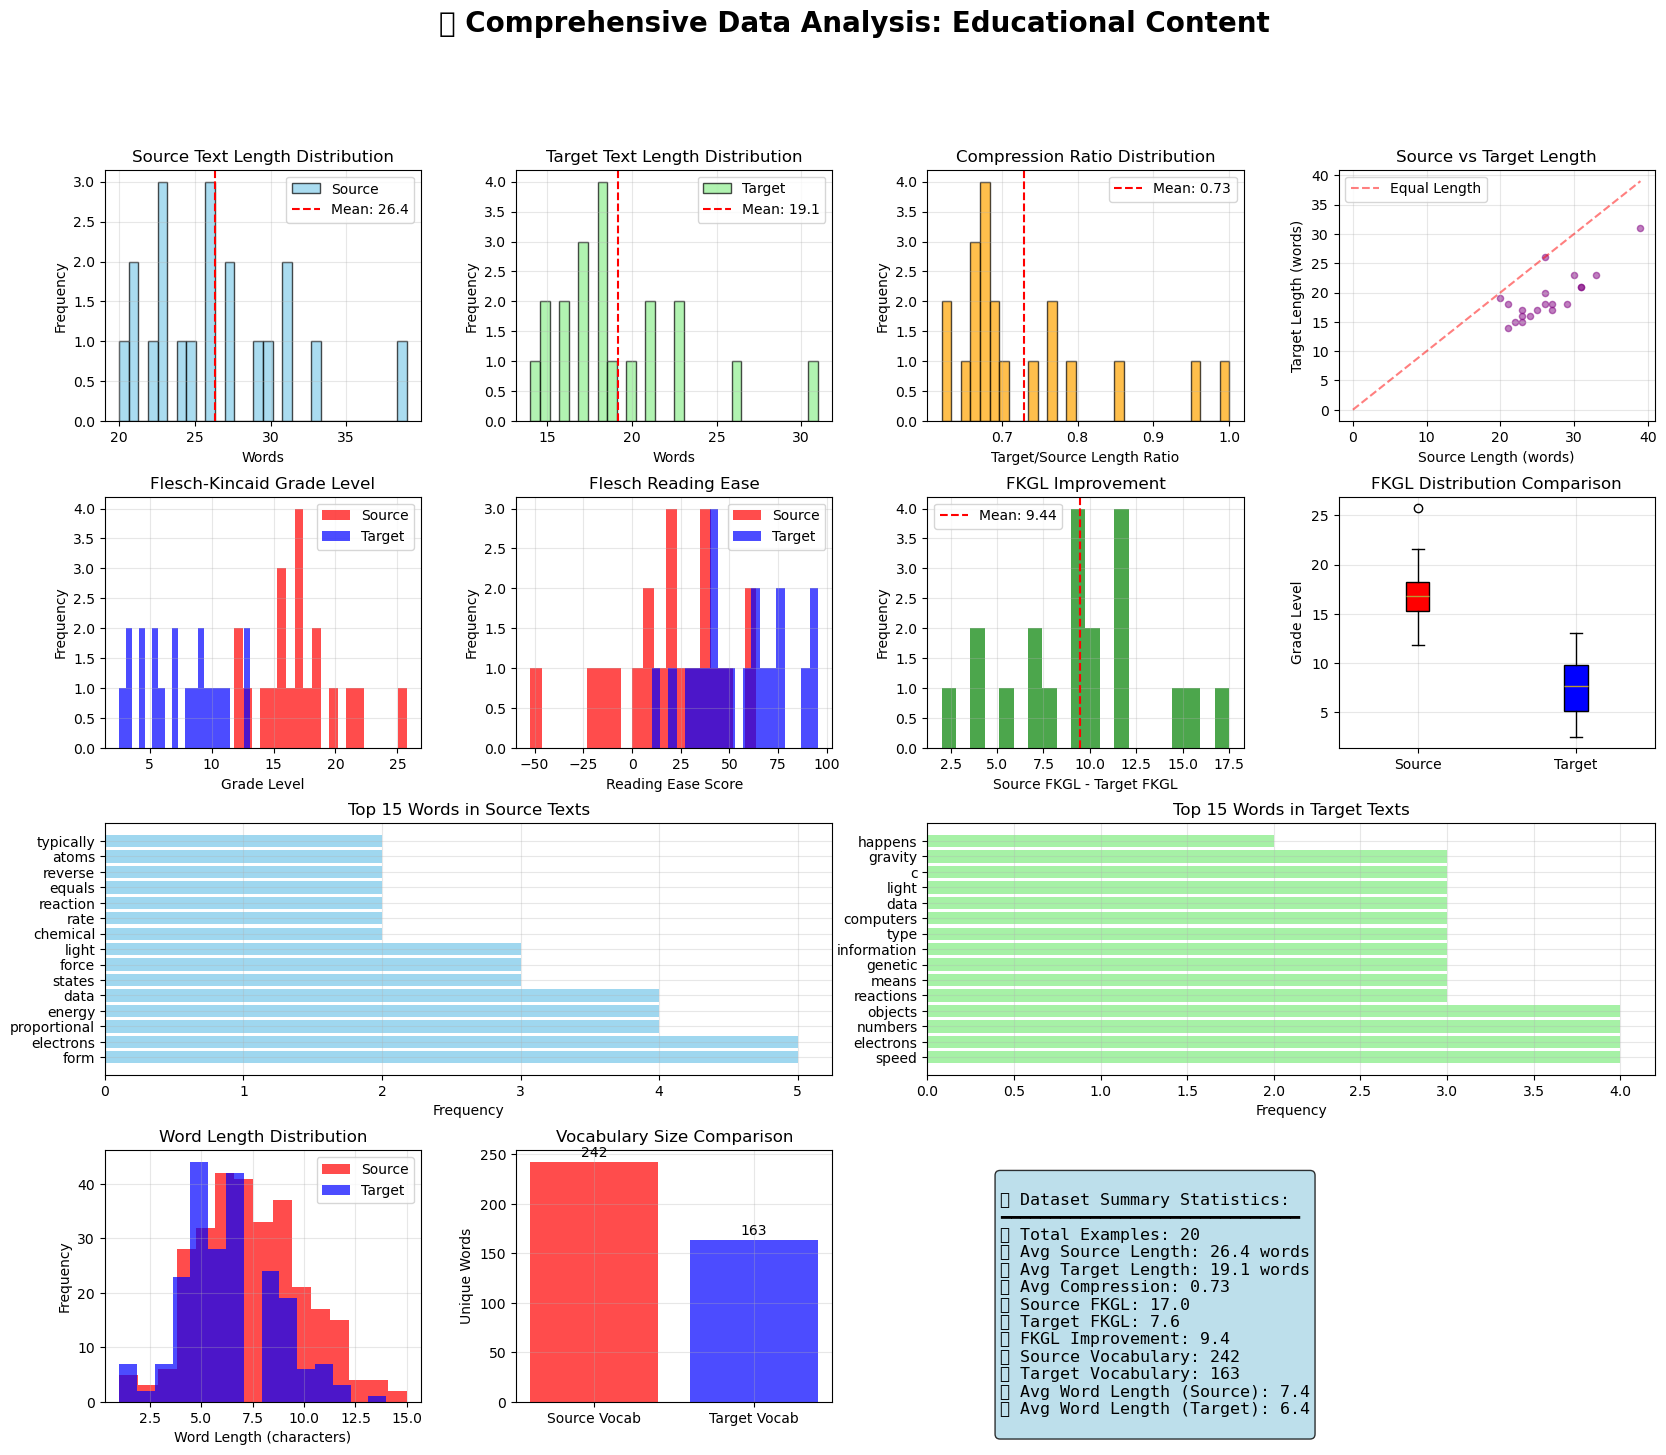

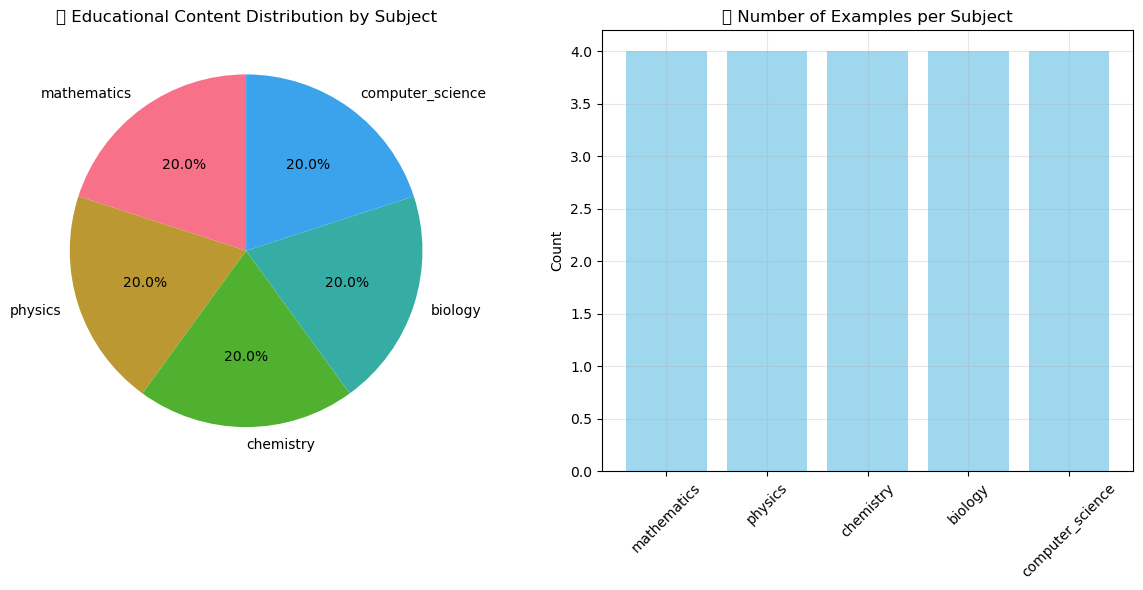

In [7]:
# Analyze educational dataset
print("🔍 Analyzing Educational Dataset...")
educational_stats = analyze_dataset_comprehensively(educational_dataset, "Educational Content")

# Subject-wise analysis
subjects = educational_dataset['subject']
subject_counts = Counter(subjects)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(subject_counts.values(), labels=subject_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title('📊 Educational Content Distribution by Subject')

plt.subplot(1, 2, 2)
plt.bar(subject_counts.keys(), subject_counts.values(), color='skyblue', alpha=0.8)
plt.title('📊 Number of Examples per Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Create Word Clouds

☁️ Creating Word Clouds...


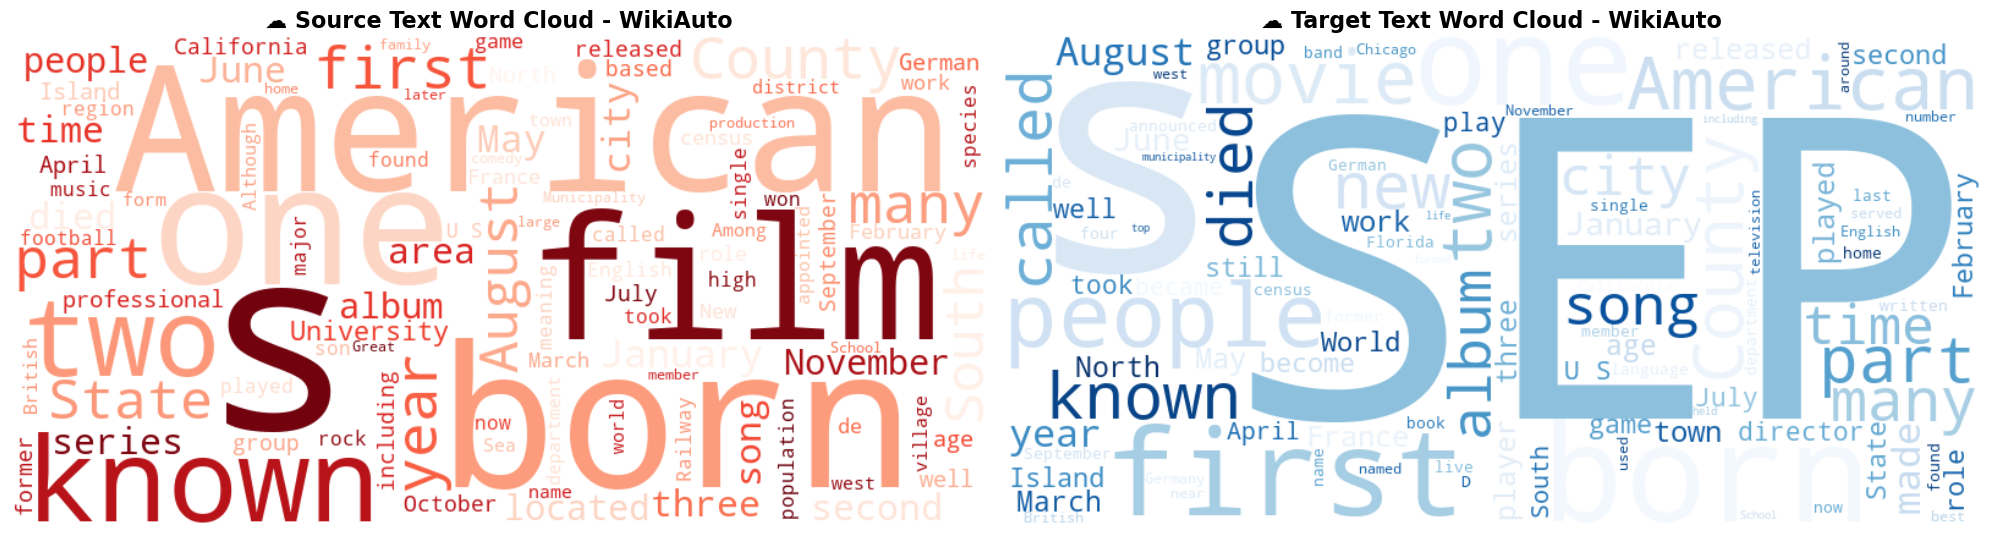

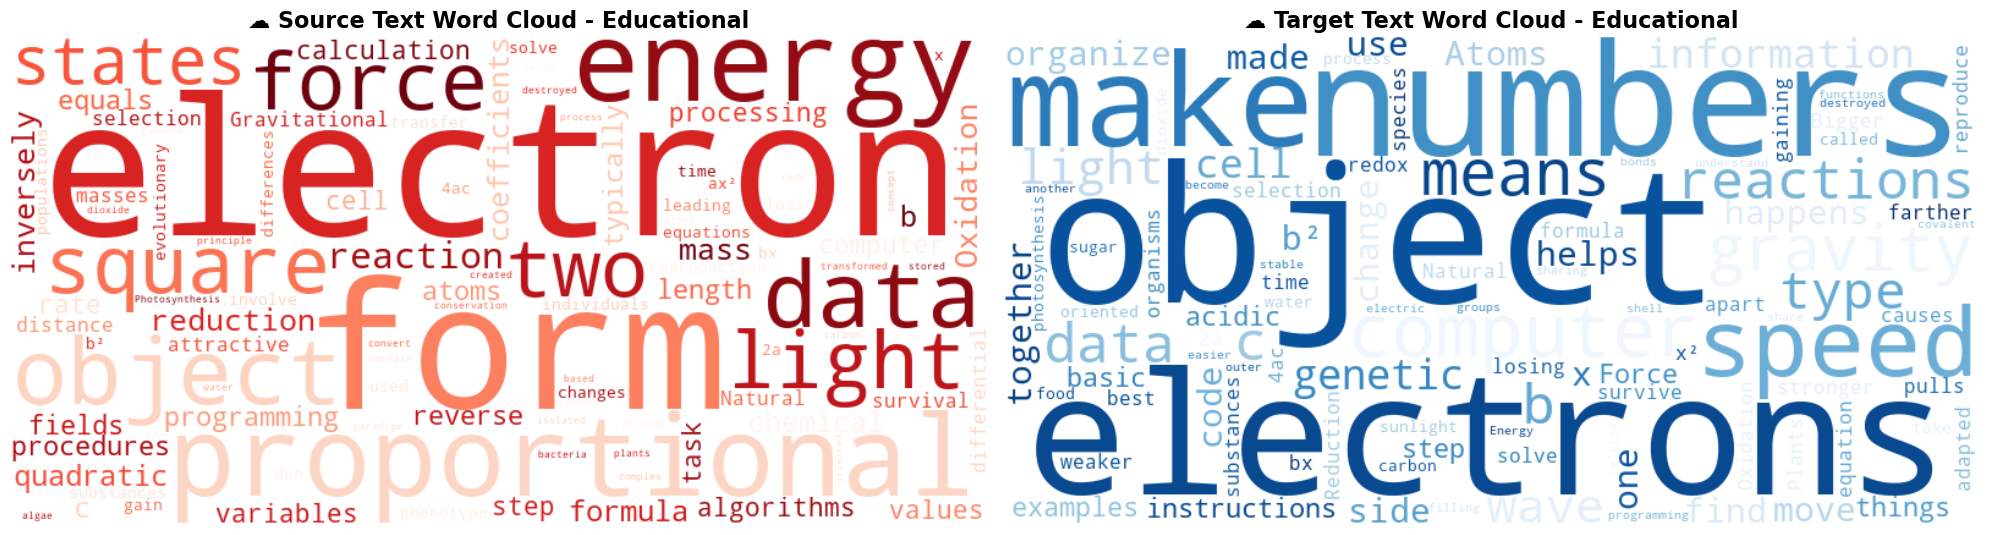

In [8]:
def create_comparative_wordclouds(dataset, name):
    """Create word clouds for source and target texts"""
    
    if 'train' in dataset:
        data = dataset['train']
    else:
        data = dataset
    
    # Sample data for word clouds
    sample_size = min(500, len(data))
    sample_data = random.sample(list(data), sample_size)
    
    source_text = " ".join([item['source'] for item in sample_data])
    target_text = " ".join([item['target'] if isinstance(item['target'], str) 
                           else item['target'][0] for item in sample_data])
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Source word cloud
    wordcloud_source = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='Reds',
        max_words=100,
        relative_scaling=0.5
    ).generate(source_text)
    
    axes[0].imshow(wordcloud_source, interpolation='bilinear')
    axes[0].set_title(f'☁️ Source Text Word Cloud - {name}', fontsize=16, fontweight='bold')
    axes[0].axis('off')
    
    # Target word cloud
    wordcloud_target = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='Blues',
        max_words=100,
        relative_scaling=0.5
    ).generate(target_text)
    
    axes[1].imshow(wordcloud_target, interpolation='bilinear')
    axes[1].set_title(f'☁️ Target Text Word Cloud - {name}', fontsize=16, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Create word clouds
print("☁️ Creating Word Clouds...")
create_comparative_wordclouds(dataset, "WikiAuto")
create_comparative_wordclouds(educational_dataset, "Educational")

## Advanced Model Architecture

### Enhanced T5 Model with Dyslexia-Specific Features

In [9]:
class DyslexiaOptimizedT5(T5ForConditionalGeneration):
    """Enhanced T5 model optimized for dyslexia-friendly text simplification"""
    
    def __init__(self, config):
        super().__init__(config)
        
        # Additional layers for dyslexia-specific features
        self.readability_head = nn.Linear(config.d_model, 1)
        self.complexity_head = nn.Linear(config.d_model, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.1)
        
        # Initialize weights
        self._init_weights(self.readability_head)
        self._init_weights(self.complexity_head)
    
    def _init_weights(self, module):
        """Initialize weights for new layers"""
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
    
    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Standard T5 forward pass
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            **kwargs
        )
        
        # Add readability prediction if in training mode
        if self.training and hasattr(outputs, 'last_hidden_state'):
            # Get encoder hidden states for readability prediction
            encoder_hidden = outputs.encoder_last_hidden_state
            pooled_hidden = encoder_hidden.mean(dim=1)  # Average pooling
            
            # Predict readability and complexity scores
            readability_score = self.readability_head(self.dropout(pooled_hidden))
            complexity_score = self.complexity_head(self.dropout(pooled_hidden))
            
            outputs.readability_score = readability_score
            outputs.complexity_score = complexity_score
        
        return outputs

class DyslexiaTextSimplifier:
    """Complete text simplification system with advanced features"""
    
    def __init__(self, model_name='t5-base', device='cpu'):
        self.model_name = model_name
        self.device = device
        
        # Initialize tokenizer
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        
        # Add special tokens for dyslexia-specific prompts
        special_tokens = [
            "[DYSLEXIA]", "[SIMPLE]", "[CONTEXT]", "[MATH]", "[SCIENCE]", 
            "[READING_LEVEL_1]", "[READING_LEVEL_2]", "[READING_LEVEL_3]"
        ]
        self.tokenizer.add_tokens(special_tokens)
        
        # Initialize model
        config = T5ForConditionalGeneration.from_pretrained(model_name).config
        self.model = DyslexiaOptimizedT5(config)
        
        # Resize embeddings for new tokens
        self.model.resize_token_embeddings(len(self.tokenizer))
        
        # Move to device
        self.model.to(self.device)
        
        print(f"🏗️ Enhanced Model Architecture: {model_name}")
        print(f"📊 Parameters: {self.count_parameters():,}")
        print(f"🔤 Vocabulary size: {len(self.tokenizer):,}")
        print(f"🎯 Device: {self.device}")
    
    def count_parameters(self):
        """Count trainable parameters"""
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    
    def display_architecture(self):
        """Display detailed model architecture"""
        print("\n🏗️ Enhanced Model Architecture:")
        print("=" * 60)
        
        config = self.model.config
        print(f"📐 Base Model: {config.model_type.upper()}")
        print(f"🧠 Hidden Size: {config.d_model}")
        print(f"🔄 Encoder Layers: {config.num_layers}")
        print(f"🔄 Decoder Layers: {config.num_decoder_layers}")
        print(f"👁️ Attention Heads: {config.num_heads}")
        print(f"🔢 Feed Forward Size: {config.d_ff}")
        print(f"📏 Max Position: {getattr(config, 'n_positions', 'Relative')}")
        
        print(f"\n🧠 Dyslexia-Specific Enhancements:")
        print(f"   📊 Readability Head: {config.d_model} → 1")
        print(f"   📈 Complexity Head: {config.d_model} → 1")
        print(f"   🎯 Special Tokens: {len(self.tokenizer) - config.vocab_size}")
        
        # Calculate layer parameters
        total_params = self.count_parameters()
        encoder_params = sum(p.numel() for p in self.model.encoder.parameters())
        decoder_params = sum(p.numel() for p in self.model.decoder.parameters())
        
        print(f"\n📊 Parameter Distribution:")
        print(f"   🔄 Encoder: {encoder_params:,} ({encoder_params/total_params*100:.1f}%)")
        print(f"   🔄 Decoder: {decoder_params:,} ({decoder_params/total_params*100:.1f}%)")
        print(f"   🧠 Enhancement Heads: {(total_params-encoder_params-decoder_params):,}")
        print(f"   📊 Total: {total_params:,}")

# Initialize the enhanced model
print("🚀 Initializing Enhanced Dyslexia Text Simplifier...")
model_system = DyslexiaTextSimplifier(model_name='t5-base', device=device)
model_system.display_architecture()

🚀 Initializing Enhanced Dyslexia Text Simplifier...


ImportError: 
T5Tokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.
